# AMS Project 553
### Benjamin Nicholson & Nick Christophedes

As part of AMS 553 at Stony Brook University the students have been tasked with a final project that looks to utilize skills learned from the class to create an advanced queueing simulation. As both Ben and Nick are Quantitative Finance students they saw an opportunity to utilize queueing theory to emulate the Log Order Book (LOB)

### Project Intention
Showcase the importance of market makers by looking at the average wait time for order to be executed / % of orders that actually get executed when there is just buyers and sellers vs buyers, sellers, and market makers.

## Methodology

In [299]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq
import simpy

In [300]:
class Distribution:
    """
    Distributions class will be used for random variate generation
    """
    def __init__(self, sampler):
        self.sampler = sampler

    def sample(self):
        return self.sampler()

In [301]:
class Order:
    def __init__(self,order_id, investor_id, price, time, side):
        """
        Attrbiutes:
        investor_id: Unique identifier for the investor placing the order
        price: The price at which the order is placed
        time: The timestamp when the order is placed
        side: 'buy' or 'sell' indicating the type of order

        """
        self.id = order_id
        self.investor_id = investor_id
        self.price = price
        self.time = time
        self.side = side

In [322]:
class OrderBook:
    """
    Attributes:
    - p0: initial price of the asset
    - bids: list of buy orders (max heap)
    - asks: list of sell orders (min heap)
    
    Methods:
    - best_bid(): returns the highest bid price
    - best_ask(): returns the lowest ask price
    - midpoint_price(): returns the midpoint price between best bid and best ask
    - add_order(order): adds an order to the order book
    """
    def __init__(self,p0):
        self.p0 = p0
        self.bids = []  # max heap 
        self.asks = []  # min heap
        self.best_bid_list = []
        self.best_ask_list = []
        self.midpoint_price_list = []
        self.next_order_id_counter = 0

    def best_bid(self):
        current_best_bid = -self.bids[0][0] if self.bids else None # use negative as heapq finds minimum 
        self.best_bid_list.append(current_best_bid) # append the best bid at each time step to the list
        return current_best_bid

    def best_ask(self):
        current_best_ask = self.asks[0][0] if self.asks else None
        self.best_ask_list.append(current_best_ask) # append the best ask at each time step to the list
        return current_best_ask

    def midpoint_price(self):
        bid = self.best_bid()
        ask = self.best_ask()
        if bid is None or ask is None: # i need to initialize the order book with a p0
            return self.p0
        midpoint = (bid + ask) / 2
        self.midpoint_price_list.append(midpoint) # append the midpoint at each time step to the list
        return midpoint

    def add_order(self, order):
        entry = (
            -order.price if order.side == "buy" else order.price,
            order.time,
            order.id,
            order.side,
            order
        )
        if order.side == "buy":
            entry = (-order.price,order.time,order.id,order)
            heapq.heappush(self.bids, entry)
        else:
            entry = (order.price,order.time,order.id,order)
            heapq.heappush(self.asks, (entry))

    def next_order_id(self): # keep a counter of the number of orders that have entered the order book
        self.next_order_id_counter += 1
        return self.next_order_id_counter

At each time step the order book is going to update with new method values. This allows us to track how these values change over time

#### Price for Investor
There are a few ways to allocate the price to an investor.
At the moment every time an investor 

In [309]:
class Investor:
    """
    Attributes:
    - id: Unique identifier for the investor
    - price_dist: Distribution object for price noise
    - arrival_dist: Distribution object for inter-arrival times
    Methods:
    - get_valuation(orderbook): returns the valuation of the investor based on the order book
    - map_price(val, noise): maps the valuation and noise to a price (to be implemented in subclasses)
    - generate_price(orderbook): generates a price based on valuation and noise

    Overview:
    An investor is a parent class to buyers and sellers.
    Each investor comes to the queue with their ID (used as an identifier), a price and an arrival time.
    """
    def __init__(self, id, price_dist, arrival_dist):
        self.id = id
        self.price_dist = price_dist
        self.arrival_dist = arrival_dist

    def get_valuation(self, orderbook):
        return orderbook.midpoint_price() # we get the value of an investor to be the mid point between best ask and best bid

    def map_price(self, val, noise):
        raise NotImplementedError

    def generate_price(self, orderbook):
        noise = self.price_dist.sample()
        val = self.get_valuation(orderbook)
        return round(self.map_price(val, noise), 2)
    
class Buyer(Investor):
    def map_price(self, val, noise): # we make sure that the noise is to the left of the midpoint as buyers will make lower than midpoint bids
        return val - noise

    def run(self, env, orderbook):
        while True:
            yield env.timeout(self.arrival_dist.sample())
            price = self.generate_price(orderbook) # we generate price by fetching the value which gets the midpoint of the orderbook between bid and ask
            order_id = orderbook.next_order_id()
            order = Order(order_id,self.id, price, env.now, "buy") # we make the order per interarrival time self, order_id, investor_id, price, time, side
            orderbook.add_order(order)


class Seller(Investor):
    def map_price(self, val, noise):
        return val + noise

    def run(self, env, orderbook):
        while True:
            yield env.timeout(self.arrival_dist.sample())
            price = self.generate_price(orderbook)
            order_id = orderbook.next_order_id()
            order = Order(order_id,self.id, price, env.now, "sell")
            orderbook.add_order(order)

In [318]:
p0 = 120
n_investors = 10

buyers_list = []
sellers_list = []

env = simpy.Environment(0) # initial start time of the simulation
orderbook = OrderBook(p0)

arrival_dist = Distribution(lambda: np.random.exponential(10)) # we want 10 arrivals a second
price_dist = Distribution(lambda: np.random.uniform()) # we want the scale to be 2

for i in range(n_investors): 
    buyer = Buyer(i,price_dist,arrival_dist)
    buyers_list.append(buyer)

for i in range(n_investors):
    seller = Seller(i,price_dist,arrival_dist) 
    sellers_list.append(seller)

for b in buyers_list: # go through each buyer
    env.process(b.run(env, orderbook))
for s in sellers_list: # go through each seller 
    env.process(s.run(env, orderbook))

env.run(until=100)

For b in buyers list and for s in sellers list we do not actually run through the simulation it essentially registers the entity with the simulation. 

In [323]:
orderbook.event_tracking

<bound method OrderBook.event_tracking of <__main__.OrderBook object at 0x150d8a6a0>>

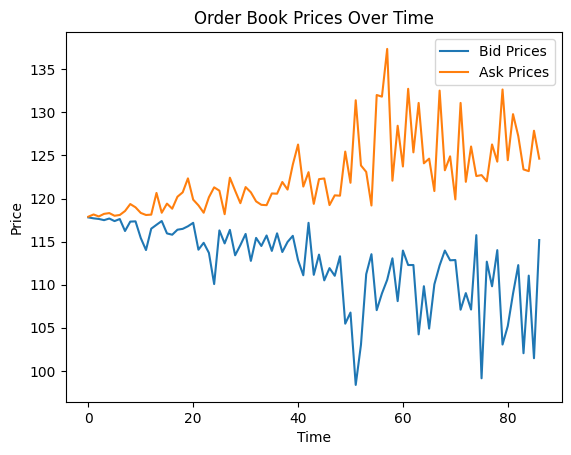

In [320]:
bid_prices = []
ask_prices = []
for i in range(len(orderbook.bids)):
    bid_prices.append(-orderbook.bids[i][0])
    ask_prices.append(orderbook.asks[i][0])

plt.plot(bid_prices,label='Bid Prices')
plt.plot(ask_prices,label='Ask Prices')
plt.title('Order Book Prices Over Time')
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend()

We can see that the bid and the ask prices begin to move away from each other as we take the best bid and the best ask price

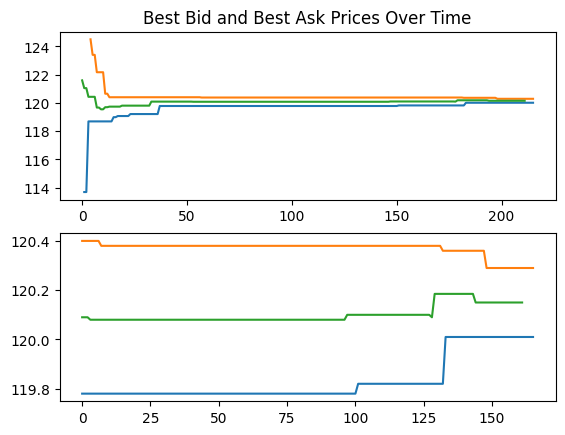

In [ ]:
plt.subplot(2,1,1)
plt.plot(orderbook.best_bid_list, label='Best Bid')
plt.plot(orderbook.best_ask_list, label='Best Ask')
plt.plot(orderbook.midpoint_price_list, label='Midpoint Price')
plt.title('Best Bid and Best Ask Prices Over Time')
plt.subplot(2,1,2)
plt.plot(orderbook.best_bid_list[50:], label='Best Bid')
plt.plot(orderbook.best_ask_list[50:], label='Best Ask')
plt.plot(orderbook.midpoint_price_list[50:], label='Midpoint Price')

#### Up Next:
Matching Algorithm
- requires binning prices
- keeping track of order book growth over time

#### Following this:
Output analysis
- Average time in Queue
- Average Number of people who get served